# Potential

The electron beam interacts with the specimen through the Coulomb potential of the electrons and nuclei in the specimen. 

## Potential parametrization

The electron charge distribution of an atom can be calculated from a first-principles electronic structure calculation, while the atomic nuclei are a point charges at the resolution of a TEM. Given a charge distribution, the potential can be obtained via Poisson's equation. 

Simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to Hartree-Fock calculations. Below we show the radial depedence of the electrostatic potential of five selected elements, using the default parametrization in abTEM. This parametrization is due to Lobato et. al., it is the latest and one of the most accurate parametrizations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.data import chemical_symbols

from abtem.parametrizations import lobato, load_lobato_parameters

parameters = load_lobato_parameters()
r = np.linspace(0, 2, 200)

plt.figure(figsize = (12, 5))

for number in [6, 7, 14, 79, 92]:
    plt.plot(r, lobato(r, parameters[number]), label=chemical_symbols[number])

plt.xlabel('r [Å]')
plt.ylabel('V [eV / e]')
plt.ylim([0, 30])
plt.legend();

The radial dependence of the atomic potential for isolated single atoms is shown above.

## Independent atom model

The full specimen potential, $V(r)$, is usually obtained as a linear superposition of the atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad ,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This is known as the Indenpendent Atom Model (IAM). This model obviously neglects any effect due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often a good approximation, which gets progressively better as the atomic number increases. Nonetheless, due to recent improvements in microscopes, interest in going beyond this approximation have started. For example, it has been shown that simulated images based on potentials from DFT calculations can provide a better match with experimental data for light elements. In a later tutorial, we go beyond the IAM using density functional theory.

Below we create a `Potential` object. This object represents a sliced potential in the IAM using a given parametrization. 

In [1]:
from ase.io import read
from abtem.potentials import Potential


srtio = read('srtio3.cif')

potential = Potential(srtio, slice_thickness=0.5, sampling=.03, parametrization='lobato')

TypeError: object.__init__() takes no parameters

Indexing a Potential returns the individual slices. Below we show three slices from the SrTiO<sub>3</sub> potential.

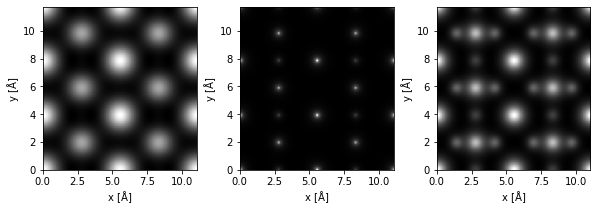

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
potential[3].show(ax=ax1)
potential[5].show(ax=ax2)
potential[7].show(ax=ax3);

## Precalculating the potential

To keep memory requirements low the `Potential` object does not store the calculated potential slices, hence if a simulation requires multiple propagations each slice is calculated from scratch every time. If the memory can be afforded, calculations can be sped up by precalculating the potential.

In [3]:
precalculated_potential = potential.calculate(pbar=True)

The precalculated potential object stores each 2d potential slice in a 3d array. The first dimension is the slice index and the last two are the spatial dimensions.

In [4]:
precalculated_potential, type(precalculated_potential.array), precalculated_potential.array.shape

(<abtem.potentials.ArrayPotential at 0x210ea112c08>,
 numpy.ndarray,
 (76, 369, 391))

The calculated potential can be stored and read back.

In [5]:
precalculated_potential.write('srtio3_110_potential.hdf5')

In [6]:
from abtem.potentials import ArrayPotential

ArrayPotential.read('srtio3_110_potential.hdf5')

## Accuracy of potential projections 

The potential of a single atom is very localize, but in principle infinite in extent, hence we can set a reasonable cutoff. The cutoff is calculated by solving the following equation

$$
V(r) = V_{tol} 
$$

where $V_{tol}$ is the error at the cut-off. The equation is solved for each species. The use of the cut-off radius creates a discontinuity, hence, abTEM uses a tapering near the cut-off. $V_{cut}$ can be modified using the `cutoff_tolerance` argument of the `Potential` object.

abTEM uses the accurate finite potential projection method for projecting potentials. Here, numerical integration is used to calculate the integrals of the form

$$
V_{proj}^{(i)}(x, y) = \int_{z_i}^{z_i+\Delta z} V(x,y,z) dz \quad ,
$$

where $z_i$ is the $z$-position at the entrance of the $i$'th slice and $\Delta z$ is the slice thickness. The slices can be arbitrarily thin, however, too thick slices thickness of $0.5$ Å is generally slim enough. 

The numerical integrals are efficiently handled by using the double exponential Tanh–Sinh quadrature, which is designed accurate result using a minimum number evaluations for functions with singularities. Once a projection with a some limits is calculated it will be cached, by default to within 0.01 Å of either limit. 